#### demo: training a DND LSTM on a contextual choice task

This is an implementation of the following paper: 
```
Ritter, S., Wang, J. X., Kurth-Nelson, Z., Jayakumar, S. M., Blundell, C., Pascanu, R., & Botvinick, M. (2018).  
Been There, Done That: Meta-Learning with Episodic Recall. arXiv [stat.ML].  
Retrieved from http://arxiv.org/abs/1805.09692
```

In [58]:
'''
If you are using google colab, uncomment and run the following lines!  
which grabs the dependencies from github
'''
# !git clone https://github.com/qihongl/dnd-lstm.git

# !cd dnd-lstm/src/
# import os
# os.chdir('dnd-lstm/src/')

'\nIf you are using google colab, uncomment and run the following lines!  \nwhich grabs the dependencies from github\n'

In [59]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from compositional_metarl.task import GridTask
from compositional_metarl.model import MultiDimQDNDLSTM as Agent
from compositional_metarl.utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import MultiStateTrainer, evaluate

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 # 100 # 0 works for 64
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [132]:
'''init task'''

start_arm = 0
end_arm = 7
ctx_dim = 2
n_arms = (end_arm - start_arm) + 1
n_rounds = 20
n_trials = 10
normalize_rewards = True
CUES =  {'linear-random': torch.tensor([1.0, 0.0]), 'random-periodic': torch.tensor([0., 1.0])}#, 'linear-periodic': torch.tensor([1.0, 1.0])} #{'linear': torch.tensor([1.0, 0.0]), 'periodic': torch.tensor([0.0, 1.0])}#, 'linperiodic': torch.tensor([1.0, 1.0])} 
task = GridTask(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=normalize_rewards)

In [133]:
'''init model and trainer'''

# DNDLSTM params
dim_hidden = 64
inp_dim = 5
inputs = 'action-reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'cosine' # 'l1' or 'l2'
dnd_policy = 'softmax' # 'softmax' or '1NN'
unique_keys = True
exclude_key = True


# training parameters
learning_rate = 1e-3 #5e-4 
n_epochs = 10
beta = 1. # weight for entropy loss
gamma = 0.6 # 0.8
normalize_return = True


# init agent and optimizer
agent = Agent(inp_dim, dim_hidden, dim_output, dict_len, inputs=inputs, ctx_dim=ctx_dim, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [134]:
trainer = MultiStateTrainer(agent, task, seed=seed_val, lr=learning_rate, n_trials=n_trials, beta=beta, gamma=gamma, normalize_return=normalize_return, early_stopping=True)

In [135]:
out, avg_train_loss, avg_cum_rewards, _ = trainer.train()

Score improved (nan --> 0.000000).


/notebooks/src/trainers/trainers.py:297: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_at1 = torch.nn.functional.softmax(q_t1.squeeze())
/notebooks/src/trainers/trainers.py:298: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_at2 = torch.nn.functional.softmax(q_t2.squeeze())
/notebooks/src/model/utils.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(r_t).type(torch.FloatTensor).data


Epoch 1 / 100| return = 0.85 | loss: val = 0.41, pol = -0.24, entropy = 4.05 | time = 4.68
Score improved (0.000000 --> 0.851116).
Epoch 2 / 100| return = 0.95 | loss: val = 0.40, pol = -0.02, entropy = 4.06 | time = 5.07
Score improved (0.851116 --> 0.947577).
Epoch 3 / 100| return = 0.92 | loss: val = 0.41, pol = -0.20, entropy = 4.08 | time = 4.63
EarlyStopping counter: 1 out of 20
Epoch 4 / 100| return = 0.95 | loss: val = 0.39, pol = -0.35, entropy = 4.07 | time = 4.70
Score improved (0.947577 --> 0.953600).
Epoch 5 / 100| return = 0.88 | loss: val = 0.37, pol = -0.27, entropy = 4.05 | time = 4.65
EarlyStopping counter: 1 out of 20
Epoch 6 / 100| return = 0.94 | loss: val = 0.36, pol = -0.47, entropy = 4.05 | time = 4.71
EarlyStopping counter: 2 out of 20
Epoch 7 / 100| return = 0.98 | loss: val = 0.38, pol = -0.49, entropy = 4.03 | time = 4.78
Score improved (0.953600 --> 0.984634).
Epoch 8 / 100| return = 1.00 | loss: val = 0.37, pol = -0.56, entropy = 4.01 | time = 4.54
Score i

In [136]:
n_epochs = trainer.current_epoch +1

## save model

## figures

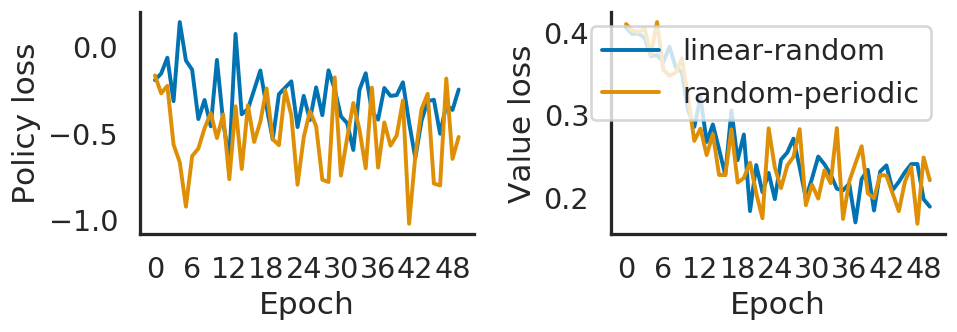

In [103]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(trainer.log_loss_policy.mean(2)[:n_epochs])
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(trainer.log_loss_value.mean(2)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(CUES)
sns.despine()
f.tight_layout()

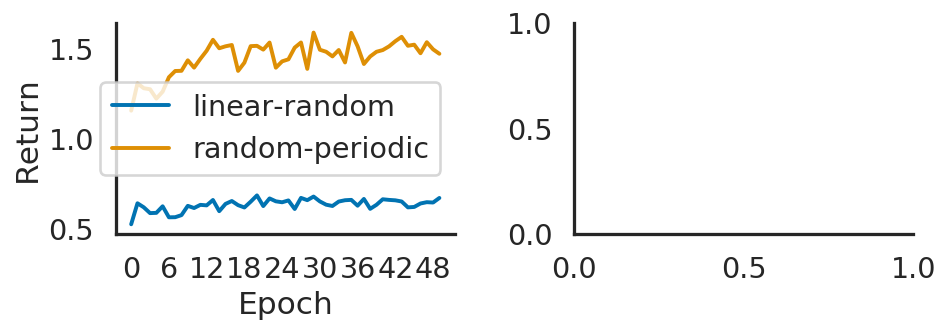

In [104]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(trainer.log_cum_return.mean(2)[:n_epochs])
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].plot(np.repeat(log_Y[:, 0, :, 7].mean(1).mean(),n_epochs), '_k')

# axes[1].plot(log_regret.mean(3).mean(2)) # mean regreat across trials and rounds
# axes[1].plot(trainer.log_regret.cumsum(3).max(3).mean(2)[:n_epochs])
# axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[1].set_ylabel('Cum. Regret')
# axes[1].set_xlabel('Epoch')

axes[0].legend(CUES)
sns.despine()
f.tight_layout()

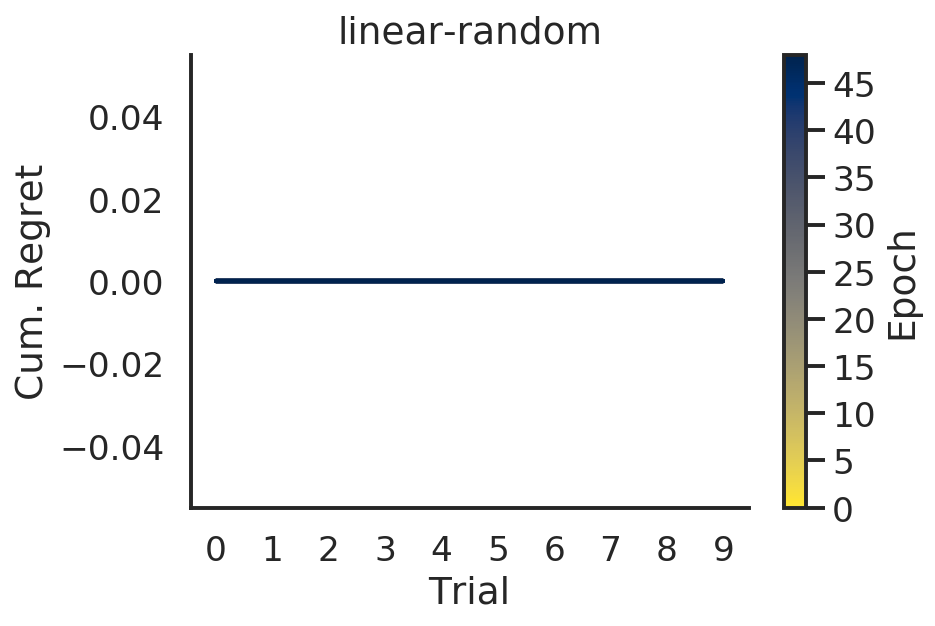

In [11]:
''' cumulative rewards across trials per epoch (averaged across episodes/rounds)'''

cue = 'linear-random'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx        
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_epochs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
cum_regret = trainer.log_regret.cumsum(3)
for ep in range(n_epochs):
    ax.plot(cum_regret[ep,cue_id,:,:].T.mean(1), linewidth=2, c=cmap.to_rgba(ep + 1))
            
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Trial',
       ylabel='Cum. Regret',
       title=cue)
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Epoch', rotation=90)
sns.despine()

for aa in ax.xaxis.get_major_ticks():
    aa.set_visible(True)

plt.show()

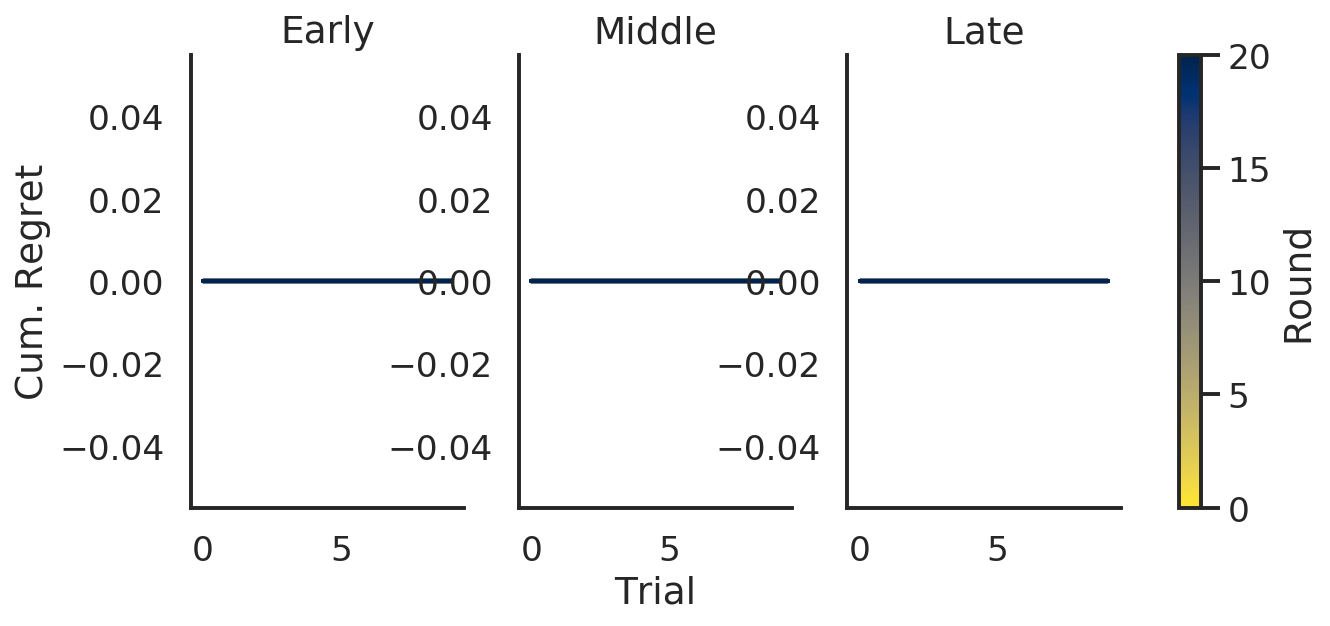

In [12]:
''' cumulative rewards across trials across rounds in early, middle, last epoch'''

cue = 'linear-random'
early_epoch = 0
middle_epoch = np.int(n_epochs/2)
late_epoch = (n_epochs - 1)

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_rounds+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=150)
cum_regret = trainer.log_regret.cumsum(3)
for rnd in range(n_rounds):
    ax[0].plot(cum_regret[early_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    ax[1].plot(cum_regret[middle_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    ax[2].plot(cum_regret[late_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set(ylabel='Cum. Regret', title='Early')
ax[1].set(xlabel='Trial', title='Middle')
ax[2].set(title='Late')

#plt.suptitle('test')
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Round', rotation=90)
sns.despine()
plt.show()


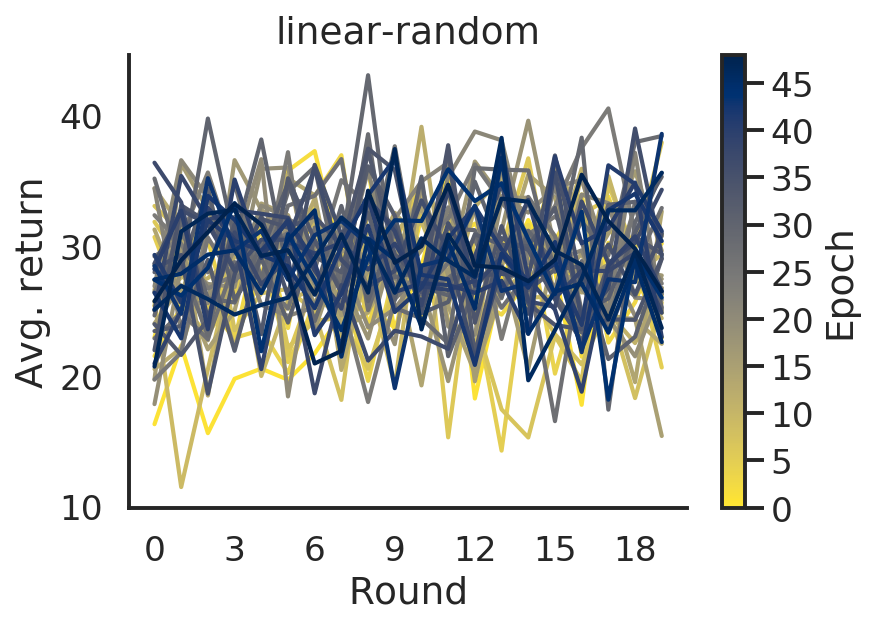

In [62]:
''' average rewards across rounds across epochs'''

cue = 'linear-random'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_epochs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
for ep in range(n_epochs):
    ax.plot(trainer.log_cum_return[ep, cue_id], linewidth=2, c=cmap.to_rgba(ep + 1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Round',
       ylabel='Avg. return',
      title=cue)
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Epoch', rotation=90)
sns.despine()
plt.show()

ValueError: cannot reshape array of size 40000 into shape (100,200)

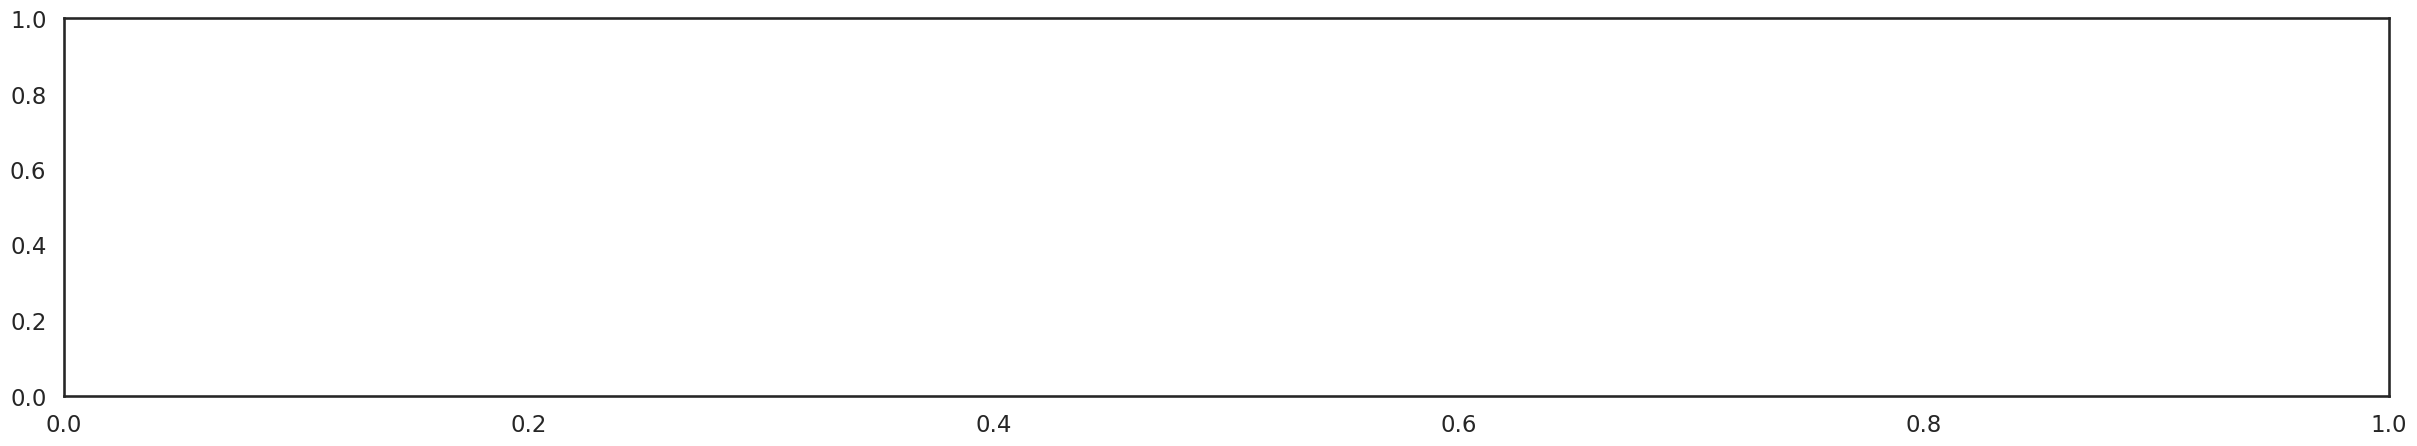

In [63]:
''' action distribution across epochs'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
f, ax = plt.subplots(1, 1, figsize=(30, 5), dpi=100)
bins = np.linspace(start_arm, end_arm+1, n_arms+1)
pulls_per_arm = plt.hist(trainer.log_Y_hat[:, cue_id, :, :].reshape(100, n_rounds*n_trials).T, bins=bins)
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set(xlabel='Arm', ylabel='No. of pulls per arm')
#ax[0].set_xlim([start_arm, end_arm+1])

f, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
ax.bar(range(n_epochs), np.vstack(pulls_per_arm[0])[:,aoi[cue]][:n_epochs]/(n_rounds*n_trials))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(ylabel='% pulls of best arm',
       xlabel='Epoch')
f.suptitle(cue)
sns.despine()
plt.savefig(cue)

In [128]:
''' model evaluation for different cues'''

cue = 'random-periodic'
n_runs = 10
CUES =  {'linear-random': torch.tensor([1.0, 0.0]), 'random-periodic': torch.tensor([2.0, 1.0]), 'linear-periodic': torch.tensor([3., 1.])} #{'linear': torch.tensor([1.0, 0.0]), 'periodic': torch.tensor([0.0, 1.0])}#, 'linperiodic': torch.tensor([1.0, 1.0])} 
task = GridTask(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=normalize_rewards)
X, Y = task.sample(end_rnd=3, cue=cue)

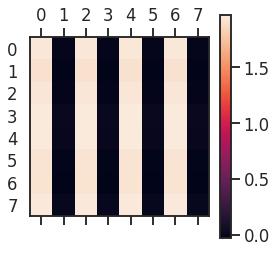

In [129]:
plt.matshow(Y[0])
plt.colorbar()
plt.show()

In [130]:
out.turn_off_retrieval()

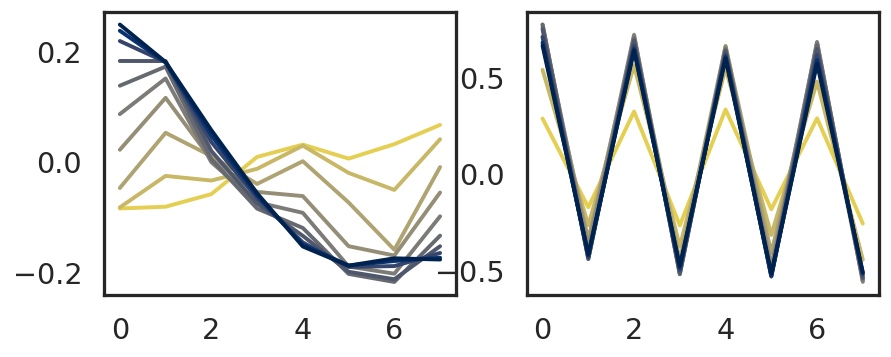

In [131]:
# params
CUES_EVAL = CUES  # {'periodic': torch.tensor([1., 0.]), 
                  #  'linear':   torch.tensor([0., 1.]), 
                  #  'linperiodic': torch.tensor([1.0, 1.0])} 
n_cues = len(CUES_EVAL)
 
# set up the color scheme
f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
c = np.arange(n_runs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# run model for n_runs
agent.eval()
agent.turn_off_encoding()

# set init states
h_t, c_t = agent.get_init_states()
h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
a_t1 = torch.randint(high=n_arms, size=(1,))
a_t2 = torch.randint(high=n_arms, size=(1,))
r_t = Y[0][a_t1, a_t2].type(torch.FloatTensor).data.reshape(-1)
actions1, actions2, dist, values, temps = [], [], [], [], []

# run model
for t in range(n_runs):
    h_t1 = h_t
    c_t1 = c_t
    x_t = CUES_EVAL[cue]  
    if inp_dim == 5:
        x_t = torch.cat((x_t, a_t1.reshape(-1).type(torch.FloatTensor), a_t2.reshape(-1).type(torch.FloatTensor), r_t.reshape(-1).type(torch.FloatTensor)), dim=0)
    output_t, c = out(x_t, h_t, c_t) 
    a_t1, prob_a_t1, v_t1, a_t2, prob_a_t2, v_t2, h_t, c_t = output_t
    f_t, i_t, o_t, rg_t, m_t, q_t1, p_at1, q_t2, p_at2 = c
    a_t1 = torch.argmax(q_t1)
    a_t2 = torch.argmax(q_t2)
    
    # bootstrap reward from q-values
    # r_t = q_t[0][a_t1, a_t2]
    r_t = Y[0][a_t1,a_t2]
    
    axes[0].plot(q_t1.detach().numpy().T, c=cmap.to_rgba(t + 1))
    axes[1].plot(q_t2.detach().numpy().T, c=cmap.to_rgba(t + 1))
    dist.append(torch.sum(F.pairwise_distance(h_t1, h_t, p=2)))
    actions1.append(a_t1) 
    actions2.append(a_t2) 
    #temps.append(rg_t) 
    #values.append(q_t[0][aoi[cue]]) 
    

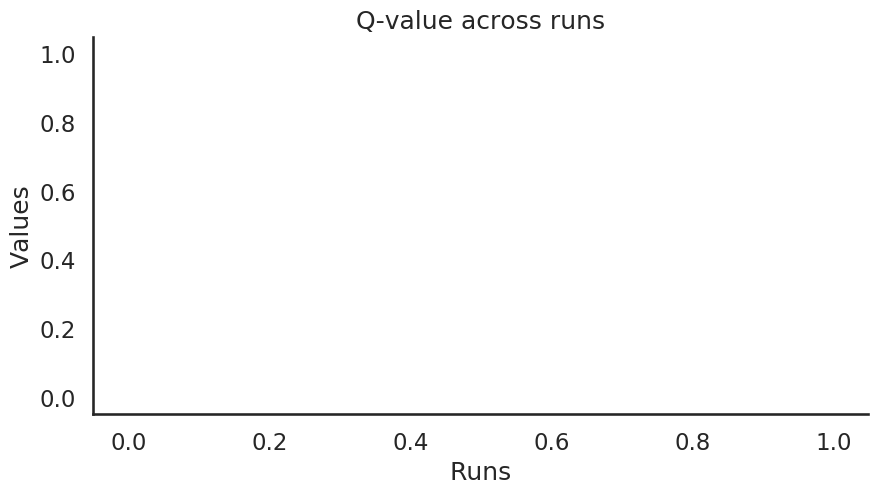

In [86]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot(values)
ax.set(xlabel='Runs',
       ylabel='Values',
      title='Q-value across runs')
sns.despine()
plt.show()

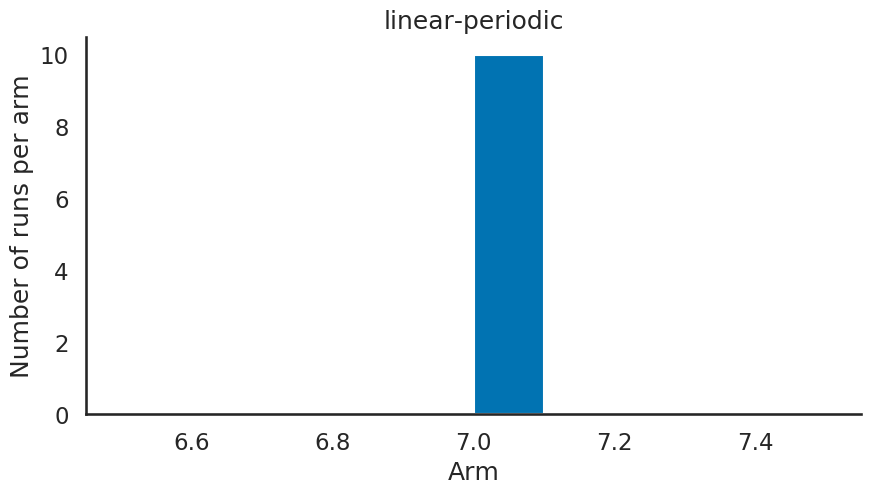

In [87]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
_ = ax.hist(actions1)
ax.set(xlabel='Arm',
       ylabel='Number of runs per arm', title = cue)
sns.despine()
plt.show()

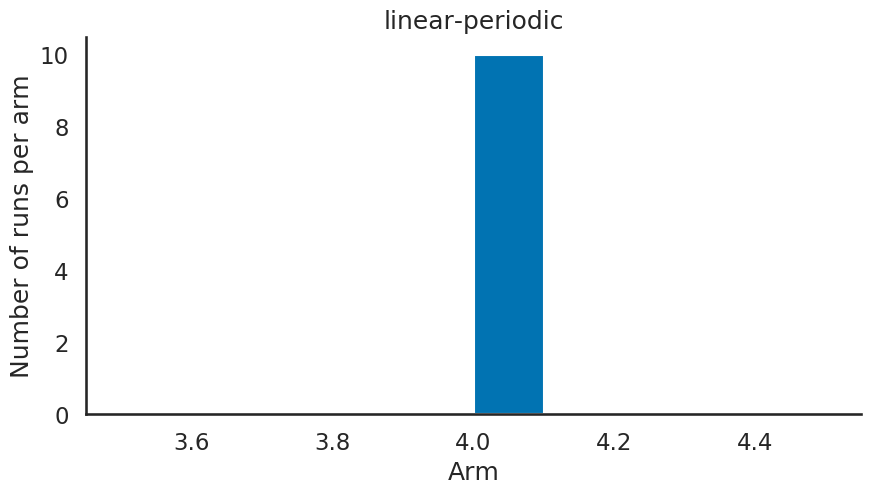

In [88]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
_ = ax.hist(actions2)
ax.set(xlabel='Arm',
       ylabel='Number of runs per arm', title = cue)
sns.despine()
plt.show()